In [ ]:
#!sudo pip install pytube

In [ ]:
#from pytube import YouTube
# def download(url):
#     youtubeObject = YouTube(url)
#     youtubeObject = youtubeObject.streams.get_lowest_resolution()
#     try:
#         youtubeObject.download()
#     except:
#         print("An error has occurred")
#     print("Download is completed successfully")

#url = "https://www.youtube.com/watch?v=FJZ-BHBKyos" # car chase
#url = "https://www.youtube.com/watch?v=1gwglom4FeA" # 8 hr nature
#url = "https://www.youtube.com/watch?v=8W1qF7l2A1c" # 6 hr nature
#download(url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CS280_final_project/wavenet_experiments
%ls

/content/drive/MyDrive/CS280_final_project/wavenet_experiments
car_chase_short.mp4  nature_short.mp4
hands_clapping.MOV   wave_vid_model_5.5_8_hr_nature.pt


In [ ]:
!sudo pip install scikit-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import soundfile as sf
import numpy as np
import skvideo.io  
import matplotlib.pyplot as plt

In [ ]:
video_string = "car_chase_short.mp4"
output_string = "wav_car_out_5.11"

In [ ]:
##NOTE: use vreader and then create a downsampled np array
## try 36x64

resized_vid_arr = []
videodata = skvideo.io.vreader(video_string)  
for v in videodata:
  roi = cv2.resize(v, (36, 64))
  roi = roi.astype("float") / 255.0
  # roi = img_to_array(roi)
  # roi = np.expand_dims(roi, axis=0)
  resized_vid_arr.append(roi) 
resized_vid_arr = np.array(resized_vid_arr)

In [ ]:
from moviepy.video.io.VideoFileClip import AudioFileClip
audioclip = AudioFileClip(video_string)
# audioclip = videoclip.audio
audio_array = audioclip.to_soundarray()
# np.save(f"8_hr_nature_numpy/8_hr_nature_aud", audio_array)

  return stacker(self.iter_chunks(fps=fps, quantize=quantize,



In [ ]:
audio_array.shape
resized_vid_arr.shape
audio_array.shape[0] / resized_vid_arr.shape[0]

1471.591719745223

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pydub 

def write(f, sr, x, normalized=True):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

# sr = (audio_array.shape[0]// resized_vid_arr.shape[0])*fps
#write('test_audio_2.mp3', sr, audio)

some code to pull the 8 hr nature video data

In [ ]:
# resized_vid_arr = np.load(f"8_hr_nature_numpy/resized_nature_vid_{0}.npy")
# for i in range(2):
#   arr2 = np.load(f"8_hr_nature_numpy/resized_nature_vid_{i+1}.npy")
#   resized_vid_arr = np.concatenate((resized_vid_arr, arr2), axis = 0)
# print(resized_vid_arr.shape)

In [ ]:
# total_num_frames = 100000*8
# percent_vid = resized_vid_arr.shape[0] / total_num_frames
# audio_array = audio_array[:int(audio_array.shape[0]*percent_vid)]
# print(audio_array.shape)

In [ ]:
# np.save(f"8_hr_nature_numpy/clipped_8_hr_nature_aud", audio_array)
# np.save(f"8_hr_nature_numpy/clipped_8_hr_nature_vid", resized_vid_arr)

In [ ]:
# # this cell loads the dataset
# audio_array = np.load("8_hr_nature_numpy/clipped_8_hr_nature_aud.npy")
# resized_vid_arr = np.load("8_hr_nature_numpy/clipped_8_hr_nature_vid.npy")

*training loop from cs189 hw*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import gc

In [ ]:
class VideoAudioDataset(Dataset):
    def __init__(self, video_frames, audio_frames, num_frames):
        self.video_frames = torch.tensor(video_frames, dtype=torch.float32).permute(0,3,2,1) # Permute to (N, C, H, W)
        self.aud_per_frame = audio_frames.shape[0]// (video_frames.shape[0])
        clip_amount = audio_frames.shape[0] % self.aud_per_frame
        self.audio_frames = torch.tensor(audio_frames[:-clip_amount], dtype=torch.float32).reshape(-1, self.aud_per_frame,audio_frames.shape[1]).permute(0,2,1) # Permute to (N, C, A)
        print(self.audio_frames.shape)
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_frames)

    def __getitem__(self, idx):
        idx += 1
        if idx < self.num_frames:
          num_zeros_needed = self.num_frames - idx
          vid_zeros = torch.zeros(num_zeros_needed, *self.video_frames[0].shape)
          aud_zeros = torch.zeros(num_zeros_needed, *self.audio_frames[0].shape)
          vid = torch.vstack((vid_zeros, self.video_frames[0:idx])).transpose(0,1)
          aud = torch.vstack((aud_zeros, self.audio_frames[0:idx])).transpose(0,1).reshape(2,-1)
          return (vid, aud)
        #vid shape example torch.Size([32, 3, 10, 36, 64])
        # aud shape example torch.Size([32, 2, 14710])
        vid = self.video_frames[idx-self.num_frames:idx].transpose(0,1)
        aud = self.audio_frames[idx-self.num_frames: (idx)].transpose(0,1).reshape(2,-1)
        # print('idx = ', idx, ' aud.size = ', aud.shape)
        return (vid, aud)

https://github.com/antecessor/Wavenet << source!

In [ ]:
class CasualDilatedConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, padding=1):
        super().__init__()
        self.conv1D = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, bias=False, padding='same')
        self.ignoreOutIndex = (kernel_size - 1) * dilation

    def forward(self, x):
        return self.conv1D(x)[..., :-self.ignoreOutIndex]


class DenseLayer(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.relu = nn.ReLU()
        #self.softmax = nn.Softmax(dim=2)
        self.tanh = nn.Tanh()
        self.conv1d = nn.Conv1d(in_channels, in_channels, kernel_size=1, bias=False)

    def forward(self, skipConnection):
        # as b c outputsize -> skipConnection size
        out = torch.mean(skipConnection, dim=0)

        for i in range(2):
            out = self.relu(out)
            out = self.conv1d(out)
        return self.tanh(out)


class ResBlock(nn.Module):
    def __init__(self, res_channels, skip_channels, kernel_size, dilation):
        super().__init__()
        self.casualDilatedConv1D = CasualDilatedConv1D(res_channels, res_channels, kernel_size, dilation=dilation)
        self.resConv1D = nn.Conv1d(res_channels, res_channels, kernel_size=1)
        self.skipConv1D = nn.Conv1d(res_channels, skip_channels, kernel_size=1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputX, skipSize):
        x = self.casualDilatedConv1D(inputX)
        x1 = self.tanh(x)
        x2 = self.sigmoid(x)
        x = x1 * x2
        resOutput = self.resConv1D(x)
        resOutput = resOutput + inputX[..., -resOutput.size(2):]
        skipOutput = self.skipConv1D(x)
        skipOutput = skipOutput[..., -skipSize:]
        return resOutput, skipOutput


class StackOfResBlocks(nn.Module):

    def __init__(self, stack_size, layer_size, res_channels, skip_channels, kernel_size):
        super().__init__()
        buildDilationFunc = np.vectorize(self.buildDilation)
        dilations = buildDilationFunc(stack_size, layer_size)
        self.resBlocks = []
        for s,dilationPerStack in enumerate(dilations):
            for l,dilation in enumerate(dilationPerStack):
                resBlock=ResBlock(res_channels, skip_channels, kernel_size, dilation)
                self.add_module(f'resBlock_{s}_{l}', resBlock) # Add modules manually
                self.resBlocks.append(resBlock)

    def buildDilation(self, stack_size, layer_size):
        # stack1=[1,2,4,8,16,...512]
        dilationsForAllStacks = []
        for stack in range(stack_size):
            dilations = []
            for layer in range(layer_size):
                dilations.append(2 ** layer)
            dilationsForAllStacks.append(dilations)
        return dilationsForAllStacks

    def forward(self, x, skipSize):
        resOutput = x
        skipOutputs = []
        for resBlock in self.resBlocks:
            resOutput, skipOutput = resBlock(resOutput, skipSize)
            skipOutputs.append(skipOutput)
        return resOutput, torch.stack(skipOutputs)


class WaveNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stack_size, layer_size):
        super().__init__()
        self.stack_size = stack_size
        self.layer_size = layer_size
        self.kernel_size = kernel_size
        self.casualConv1D = CasualDilatedConv1D(in_channels, in_channels, kernel_size, dilation=1)
        self.stackResBlock = StackOfResBlocks(self.stack_size, self.layer_size, in_channels, out_channels, kernel_size)
        self.denseLayer = DenseLayer(out_channels)
        #self.output_proj = nn.Linear(13259,1) ## need to update this for different lengths of audio
        self.tanh = nn.Tanh()


    def calculateReceptiveField(self):
        return np.sum([(self.kernel_size - 1) * (2 ** l) for l in range(self.layer_size)] * self.stack_size)

    def calculateOutputSize(self, x):
        return int(x.size(2)) - self.calculateReceptiveField()

    def forward(self, x):
        # x: b c t -> input data size
        x = self.casualConv1D(x)
        skipSize = self.calculateOutputSize(x)
        _, skipConnections = self.stackResBlock(x, skipSize)
        dense=self.denseLayer(skipConnections)
        #dense=self.output_proj(dense)
        dense=self.tanh(dense)

        return dense[:,:,-1]

    

In [ ]:
class ConvResBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.1, stride=1, kernel_size=3, padding=1):
        super(ConvResBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        self.norm1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.norm2 = nn.BatchNorm3d(out_channels)
        self.stride = stride
        
        if in_channels == out_channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm3d(out_channels)
            )
            
    def forward(self, x):
        residual = self.skip_connection(x)
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.dropout(out)
        
        out = self.relu(out)
        out = out + residual

        return out

class ConvResBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.1, stride=1, kernel_size=3, padding=1):
        super(ConvResBlock2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        
        if in_channels == out_channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        residual = self.skip_connection(x)
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.dropout(out)
        
        out = self.relu(out)
        out = out + residual

        return out

In [ ]:
class VidToAudFusion(nn.Module):
    def __init__(self, audio_dim, video_dims, audio_channels, vid_channels, dropout_prob=0.1, num_frames=10):
        super(VidToAudFusion, self).__init__()
        self.dim_proj = nn.Linear(video_dims[0] * video_dims[1], audio_dim)
        self.audio_dim = audio_dim
        self.video_dims = video_dims
        self.vid_channels = vid_channels

        if audio_channels == vid_channels:
            self.channel_projection = nn.Identity()
        else:
            self.channel_projection = nn.Sequential(
                nn.Conv2d(vid_channels, audio_channels, kernel_size=1, stride=1, bias=True),
            )
        self.channel_projection2 = nn.Sequential(
                nn.Conv1d(num_frames, 2, kernel_size=1, stride=1, bias=True),
            )
            
    def forward(self, x):
      #x = x.reshape(x.shape[0], x.shape[1], x.shape[2], -1)
      x = torch.flatten(x, start_dim=3)
      audio_proj = self.dim_proj(x)
      # print(audio_proj.shape)
      audio_proj = self.channel_projection(audio_proj).squeeze()
      audio_proj = self.channel_projection2(audio_proj)

      # print(audio_proj.shape, 'output vid to aud shape')
      return audio_proj

In [ ]:
### combines video into audio input vector and then passes through wavenet

class WaveVideoNet(nn.Module):
    def __init__(self,audio_input_shape, video_input_shape,in_channels=2,out_channels=2,kernel_size=2,stack_size=23,layer_size=6): ## NEED TO DEBUG THESE hyperperams 4.29
        super().__init__()
        self.wavenet=WaveNet(in_channels,out_channels,kernel_size,stack_size,layer_size) 
        self.tanh = nn.Tanh()
        self.vid_convs = nn.ModuleList([
            ConvResBlock3D(3, 64),
            ConvResBlock3D(64, 128),
            ConvResBlock3D(128, 256)
        ])
        self.audio_input_shape = audio_input_shape
        self.video_input_shape = video_input_shape
        vid_dims_list = self.get_video_dims(video_input_shape)
        self.vid_to_aud = VidToAudFusion(self.audio_input_shape[-1], vid_dims_list[2], 1, 256, num_frames=video_input_shape[2])
        
        

    def get_video_dims(self, video_input_shape):
        shape_list = []
        test_data = torch.ones(video_input_shape)
        out = self.vid_convs[0](test_data)
        shape_list.append((out.shape[-2],out.shape[-1]))
        for layer in self.vid_convs[1:]:
            out = layer(out)
            shape_list.append((out.shape[-2],out.shape[-1]))
        return shape_list

    def forward(self,vid, aud):
        for i in range(len(self.vid_convs)):
          vid = self.vid_convs[i](vid)
        vid_to_aud = self.vid_to_aud(vid)
        # print(vid_to_aud.shape, aud.shape)
        aud = aud + vid_to_aud
        aud=self.wavenet(aud)
        return self.tanh(aud)



In [ ]:
print(resized_vid_arr.shape, resized_vid_arr.size)
print(audio_array.size)

(1570, 64, 36, 3) 10851840
4620798


In [ ]:
train_data = VideoAudioDataset(resized_vid_arr[:int(len(resized_vid_arr)*0.8)], audio_array[:int(len(audio_array)*0.8)], num_frames = 10)
valid_data = VideoAudioDataset(resized_vid_arr[int(len(resized_vid_arr)*0.8):], audio_array[int(len(audio_array)*0.8):], num_frames = 10)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

torch.Size([1256, 2, 1471])
torch.Size([314, 2, 1471])


In [ ]:
audio_array[int(len(audio_array)*0.8):].shape

(462080, 2)

In [ ]:
for x in train_loader:
  print(x[0].shape)
  print(x[1].shape)
  break
  
count = 0
# for x in valid_loader:
#   count += 1
#   if count == 10:
#     print(x[0].shape)
#     print(x[1].shape)
#     break

torch.Size([16, 3, 10, 36, 64])
torch.Size([16, 2, 14710])


In [74]:
from tqdm.notebook import tqdm, trange

# wavenet = WaveNet(in_channels=2,out_channels=2,kernel_size=2,stack_size=23,layer_size=6).cuda().train()
audio_test_data = torch.ones((1,2,14709))
vid_test_data = torch.ones((1,3,10,36,64))

# wavenet = WaveVideoNet(audio_input_shape=audio_test_data.shape, video_input_shape=vid_test_data.shape,in_channels=2,out_channels=2,kernel_size=2,stack_size=63,layer_size=6).cuda().train()


optimizer=torch.optim.AdamW(wavenet.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
lossFunction = torch.nn.CrossEntropyLoss()

def calc_accuracy(Out,Y):
    max_vals, max_indices = torch.max(Out,1)
    train_acc = (max_indices == Y).sum().item()/max_indices.size()[0]
    return train_acc
  
epochs= 20
globalStep=500

val_loss_list = []

for epoch in range(epochs):
    for step, (vid_frames,aud_frames) in tqdm(enumerate(train_loader),desc="Training"):
         #vid_frames = vid_frames.cuda()
         target = aud_frames[:,:,-1].cuda()
         aud_frames = aud_frames[:,:,:-1].cuda()
         vid_frames = vid_frames.cuda()
        #  print(target.shape)
        #  print(aud_frames.shape)
         output = wavenet(vid_frames, aud_frames).squeeze()
         #print(output[0].detach().cpu().numpy(), target[0].cpu().numpy())
         #print(output.shape)
         #print(output)
         #print(output.dtype, target.dtype)

         loss = lossFunction(output,target)
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         if step%globalStep==0:
            # scheduler.step()
            # print(output.detach().numpy())
            # print(y_train.numpy())
            with torch.no_grad():
                accuracy=0
                val_loss=0
                for stepTest, (vid_frames,aud_frames) in tqdm(enumerate(valid_loader),desc="Validation"):
                    
                    if aud_frames.shape[2] < audio_test_data.shape[2]:
                        zeros = torch.zeros(aud_frames.shape[0], aud_frames.shape[1], audio_test_data.shape[2]+1)
                        # print('zeros shape',zeros.shape)
                        zeros[:, :, audio_test_data.shape[2] - aud_frames.shape[2] + 1:] = aud_frames
                        
                        aud_frames = zeros
                        # print(aud_frames)
                    vid_frames = vid_frames.cuda()
                    target = aud_frames[:,:,-1].cuda()
                    aud_frames = aud_frames[:,:,:-1].cuda()
                    output = wavenet(vid_frames, aud_frames).squeeze()

                    #accuracy+=calc_accuracy(output,target)*100
                    # print(output)
                    # print(target)
                    val_loss+= lossFunction(output,target).item()
                    if stepTest>200:
                        break
            print(f"loss for step {step} : {val_loss/stepTest}")
            val_loss_list.append(val_loss/stepTest)

         
    print(f"epch {epoch}")

#     save_path = 'wave_vid_model_5.5_8_hr_nature.pt'
#     torch.save(wavenet.state_dict(), save_path)
# val_loss_arr = np.array(val_loss_list)
# np.save(f"8_hr_nature_numpy/8_hr_nature_loss_5.5", val_loss_arr)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.03300837358753932
epch 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.024281594412107217
epch 1


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.030224322488433437
epch 2


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.03269125540789805
epch 3


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.033652934588884055
epch 4


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.030976078227946634
epch 5


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.037856154535946096
epch 6


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.02865375284301607
epch 7


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.03233328991030392
epch 8


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.031127631272140303
epch 9


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.03350537270307541
epch 10


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.03383855962831723
epch 11


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.034319204719443074
epch 12


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.036074317893699595
epch 13


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.038172400115351925
epch 14


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.030208352953195572
epch 15


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

loss for step 0 : -0.03728940886886496


KeyboardInterrupt: ignored

In [ ]:
class VideoOnlyDataset(Dataset):
    def __init__(self, video_frames, num_frames):
        self.video_frames = torch.tensor(video_frames, dtype=torch.float32).permute(0,3,2,1) # Permute to (N, C, H, W)
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_frames)

    def __getitem__(self, idx):
        idx += 1
        if idx < self.num_frames:
          num_zeros_needed = self.num_frames - idx
          vid_zeros = torch.zeros(num_zeros_needed, *self.video_frames[0].shape)
          vid = torch.vstack((vid_zeros, self.video_frames[0:idx])).transpose(0,1)
          return vid
        #vid shape example torch.Size([32, 3, 10, 36, 64])
        # aud shape example torch.Size([32, 2, 14710])
        vid = self.video_frames[idx-self.num_frames:idx].transpose(0,1)
        # print('idx = ', idx, ' aud.size = ', aud.shape)
        return vid

In [75]:
## get the data again
#NOTE: use vreader and then create a downsampled np array
resized_vid_arr = []
larger_vid_arr = []
videodata = skvideo.io.vreader(video_string)  

# count = 0 
# for v in videodata:
#   count += 1
#   if count % 3 == 0:
#     roi = cv2.resize(v, (36, 64))
#     roi = roi.astype("float") / 255.0
#     resized_vid_arr.append(roi) 
#     larger_vid_arr.append(v)
# resized_vid_arr = np.array(resized_vid_arr)

resized_vid_arr = []
videodata = skvideo.io.vreader(video_string)  
for v in videodata:
  roi = cv2.resize(v, (36, 64))
  roi = roi.astype("float") / 255.0
  # roi = img_to_array(roi)
  # roi = np.expand_dims(roi, axis=0)
  resized_vid_arr.append(roi) 
  larger_vid_arr.append(v)
resized_vid_arr = np.array(resized_vid_arr)

from moviepy.video.io.VideoFileClip import AudioFileClip
audioclip = AudioFileClip(video_string)
# audioclip = videoclip.audio
audio_array = audioclip.to_soundarray()

  return stacker(self.iter_chunks(fps=fps, quantize=quantize,



In [ ]:
len(larger_vid_arr)

523

In [ ]:
num_frames = 10

start_percent = 0.8

start_index = int(len(resized_vid_arr)*start_percent) + num_frames
audio_list = []
vid_test_shape = (1,3,10,36,64)
zero_frame = torch.zeros((vid_test_shape[3], vid_test_shape[4]))

aud_per_vid_frame = audio_array.shape[0]//resized_vid_arr.shape[0]
audio_start_index = int(len(audio_array)*start_percent)
print(audio_start_index)
aud_input_arr = torch.tensor(audio_array[audio_start_index:audio_start_index+14710 - 1], dtype=torch.float32).cuda().T.unsqueeze(0)
print(aud_input_arr.shape)

#aud_input_arr = torch.zeros((1,2,(num_frames * aud_per_vid_frame) - 1)).cuda()
print(aud_input_arr.shape)

input_vid = resized_vid_arr[start_index:]
larger_vid_arr = larger_vid_arr[start_index:]
gen_data = VideoOnlyDataset(input_vid, num_frames = num_frames)
gen_loader = DataLoader(gen_data, batch_size=1, shuffle=False)

video_list = []

max_count = 30

#NOTE: GEN NEEDS TO BE FIXED TO ACCOUNT FOR MULTIPLE AUDIO RUNS PER FRAME
wavenet.eval()
for i,vid in enumerate(gen_loader):
    vid = vid.cuda()
    print(vid.shape)
    if i >= max_count:
      break
    video_list.append(larger_vid_arr[i])
    for j in trange(aud_per_vid_frame):
        with torch.no_grad():
            # print(aud_input_arr.get_device())
            # print(vid.get_device())
            audio_output = wavenet(vid.cuda(), aud_input_arr.cuda()).cpu()
            # print(audio_output)
        audio_list.append(audio_output.squeeze().cpu().numpy())
        aud_input_arr = aud_input_arr[:, :, 1:]
        aud_input_arr = torch.cat((aud_input_arr, audio_output.cuda().unsqueeze(2)), 2)

np.array(audio_list).shape


video_np = np.array(video_list)
audio_np = np.array(audio_list).transpose(1,0)
print(np.array(audio_list).shape)
audio_np = np.array(audio_list).transpose(1,0)
# fps = 10
# sr = (audio_array.shape[0]// resized_vid_arr.shape[0])*fps
# write('5.8_transformer_clap_aud_out_4_test.mp3', sr, audio_np)

1848319
torch.Size([1, 2, 14709])
torch.Size([1, 2, 14709])
torch.Size([1, 3, 10, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 10, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 10, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 10, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

In [63]:
video_np = np.array(video_list)
audio_np = np.array(audio_list).transpose(1,0)
print(np.array(audio_list).shape)
audio_np = np.array(audio_list).transpose(1,0)

(24467, 2)


In [64]:
audio_np.shape[1]/video_np.shape[0]
# audio_np = np.array(audio_list).transpose(1,0)
# audio_np.shape

1439.235294117647

In [ ]:
video_np.shape

(5, 720, 1280, 3)

In [66]:
fps = 30
def make_frame(t):
  t = int(t * fps)
  # print(t)
  return video_np[t]

from moviepy.video.io.VideoFileClip import VideoClip
myclip = VideoClip(make_frame, duration = 3)
vid_out_path = output_string + 'vid.mp4'
myclip.write_videofile(vid_out_path, fps = 10)

Moviepy - Building video wav_car_out_5.11vid.mp4.
Moviepy - Writing video wav_car_out_5.11vid.mp4



Moviepy - Done !
Moviepy - video ready wav_car_out_5.11vid.mp4


In [72]:
fps = 90
# sr = (audio_array.shape[1]// resized_vid_arr.shape[0])*fps
sr = 1470*30
print(sr, audio_np.shape)
aud_out_path = output_string + 'aud.mp3'
write(aud_out_path, sr, audio_np)

44100 (2, 24467)


In [73]:
from moviepy.editor import *
  
clip = VideoFileClip(vid_out_path)
  
clip = clip.subclip(0, 0.3)
  
# loading audio file
audioclip = AudioFileClip(aud_out_path)
  
# adding audio to the video clip
videoclip = clip.set_audio(audioclip)
vid_aud_out_path = aud_out_path = output_string + 'aud_vid.mp4'
videoclip.write_videofile(vid_aud_out_path, fps = 10)
  
# showing video clip
videoclip.ipython_display()

Moviepy - Building video wav_car_out_5.11aud_vid.mp4.
MoviePy - Writing audio in wav_car_out_5.11aud_vidTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video wav_car_out_5.11aud_vid.mp4



Moviepy - Done !
Moviepy - video ready wav_car_out_5.11aud_vid.mp4
Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
audio_np.shape

(2, 21097)

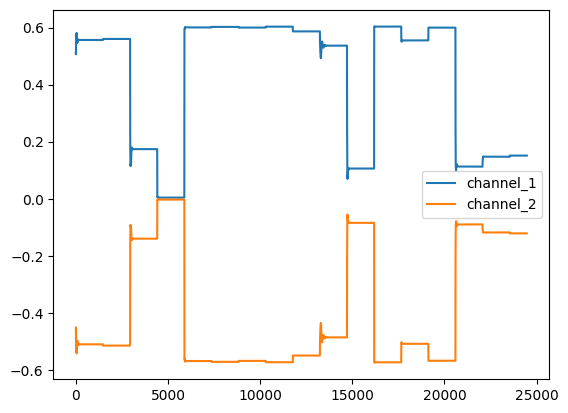

In [70]:
plt.plot(range(audio_np.shape[1]), audio_np[0], label = 'channel_1')
plt.plot(range(audio_np.shape[1]), audio_np[1], label = 'channel_2')
plt.title('Wavenet-based Sample Model Output')
plt.legend()
plt.show()